In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

In [2]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [3]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/MHI'
fname = 'gsa.17k/SGR-2227_MHI_biobank_GSAv3.0MD_609343_SNPs_16707_ids_2021-01-04.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.raw.cols1and7toend.hdf5'
metadata_file = 'MHI_poplabels.tsv'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs_mhi, _, samples_mhi, snp_names_mhi, _, metadata_mhi = data_loader.load_data_MHI(data_path, metadata_path)
#pca_input = pd.read_csv('/lustre06/project/6065672/shared/MHI_GWAS_SHUANG/MHI_PCA')

In [4]:
# label colors are arbitrary
label_order_mhi, pop_pallette_mhi = make_palette_order(metadata_mhi)

In [5]:
# Severely imbalanced
np.unique(metadata_mhi['selfreported_pop'], return_counts=True)

(array(['Asian', 'Black', 'Caucasian', 'Hispanic', 'Native', 'NotDone'],
       dtype=object),
 array([   66,   126, 16349,   118,     9,     4]))

In [38]:
## Load 1000G and fit PCA to it.
# On Compute Canada, Cannot load from drive! Instead load a local copy
def load_from_drive(url):
    # Download the data
    response = requests.get(url)
    data = response.content

    # Load into a DataFrame
    df = pd.read_csv(BytesIO(data))
    df.set_index('Unnamed: 0', inplace=True)
    return df

# Download data and metadata from direct download links
#inputs = load_from_drive('https://drive.google.com/uc?export=download&id=1HjK4lGImHr1WKDaz3me8Jj7FJ72S0WzL')
#labels = load_from_drive('https://drive.google.com/uc?export=download&id=1egE-5_MaCbTjQeJn6fbogcBjlXAsxSrg')
#admix_ratios = load_from_drive('https://drive.google.com/uc?export=download&id=1mYHRCkToVDa2S0cQXKlHzKHDBqb75ozC')

def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs_1K = load_from_local('../data/1000G/1000G_PCA')
labels_1K = load_from_local('../data/1000G/1000G_labels')
admix_ratios_1K = load_from_local('../data/1000G/1000G_admix_ratios')

exp_path_1K = '/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/data/1000G'
fname_1K = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed.hdf5'
inputs_raw_1K, _, samples_1K, snp_name_1Ks, _ = data_loader.load_data_1000G(os.path.join(exp_path_1K, fname_1K))

In [10]:
from sklearn.decomposition import PCA

# Fit PCA model
pca_1K = PCA(n_components=100)  # Number of components to keep
pca_1K.fit(inputs_raw_1K)
pca_input_1K = pca_1K.transform(inputs_raw_1K)

In [33]:
metadata_mhi['selfreported_pop']

ID
BIO-04570558-13    Caucasian
BIO-05767049-16    Caucasian
BIO-05474739-14    Caucasian
BIO-02731957-10    Caucasian
BIO-05970882-17    Caucasian
                     ...    
BIO-06013813-17    Caucasian
BIO-06020533-17    Caucasian
BIO-05583002-15    Caucasian
BIO-04671728-13    Caucasian
BIO-01338726-09    Caucasian
Name: selfreported_pop, Length: 16672, dtype: object

<Axes: title={'center': 'PCA Plot'}>

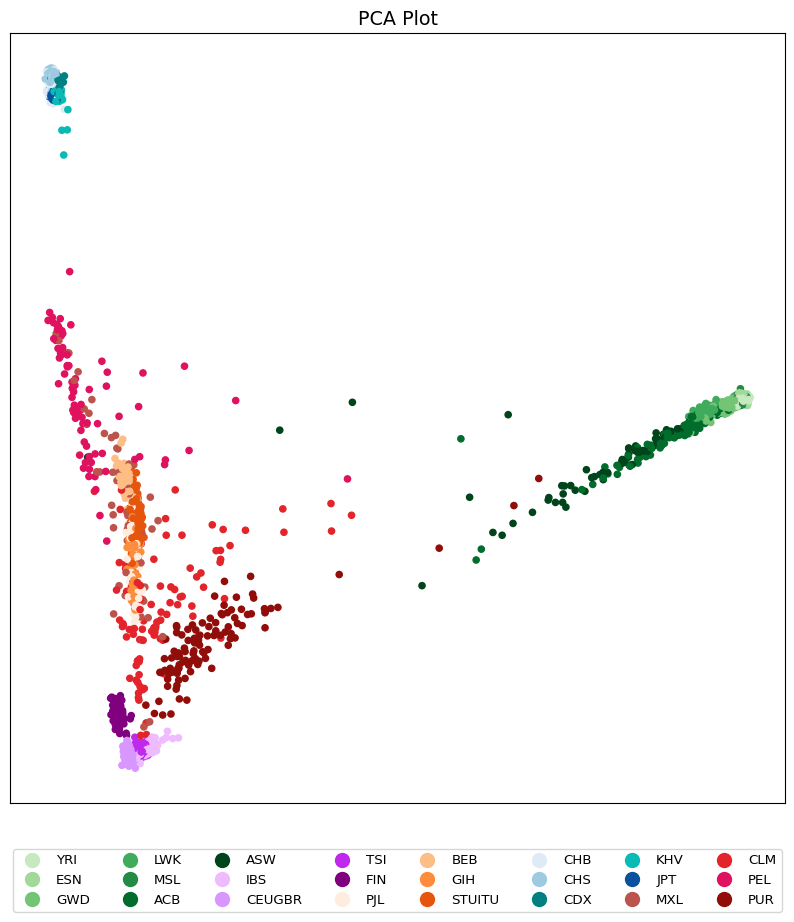

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

In [50]:
# Project MHI onto 1000G
pca_input_mhi = pca_1K.transform(inputs_mhi)

/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/scprep/plot/scatter.py:438: UserWarning: Cannot create a legend with constant `c=black`
  warnings.warn(


<Axes: title={'center': 'PCA Plot'}>

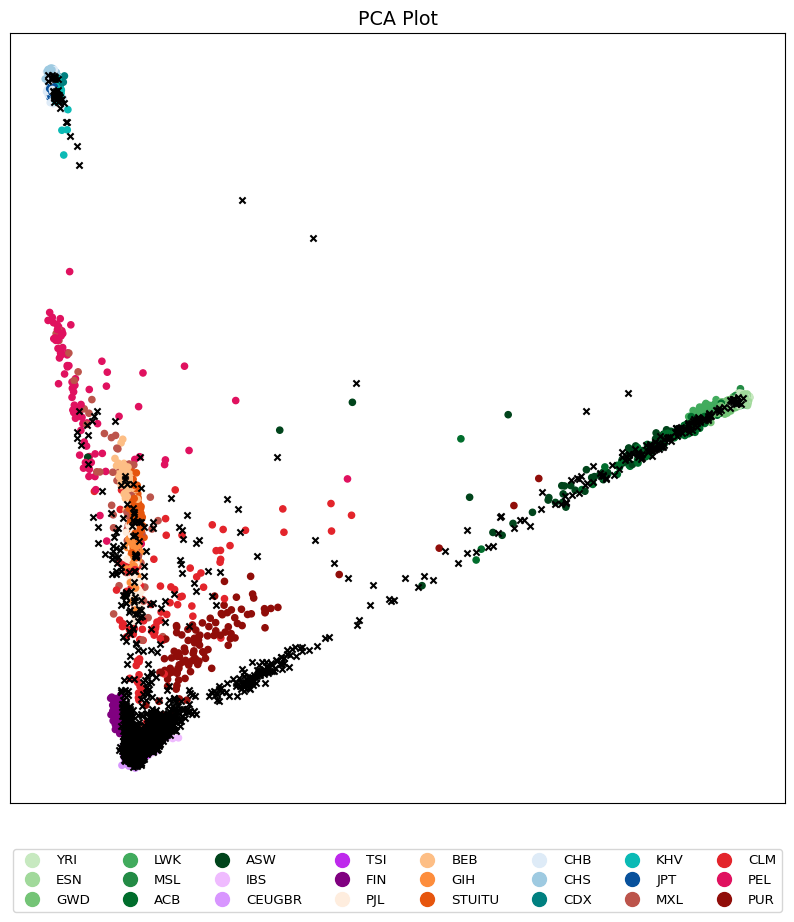

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
scprep.plot.scatter2d(pca_input_1K[:, [0, 1]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax,
                      c = labels_1K['population'], xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

scprep.plot.scatter2d(pca_input_mhi[:, [0, 1]], c='black', marker='x', s = 20, ax=ax, xticks=False, yticks=False,
                      legend=True, legend_loc='lower center', legend_anchor=(0.5, -0.15), legend_ncol=8,
                      title='PCA Plot',fontsize=8)

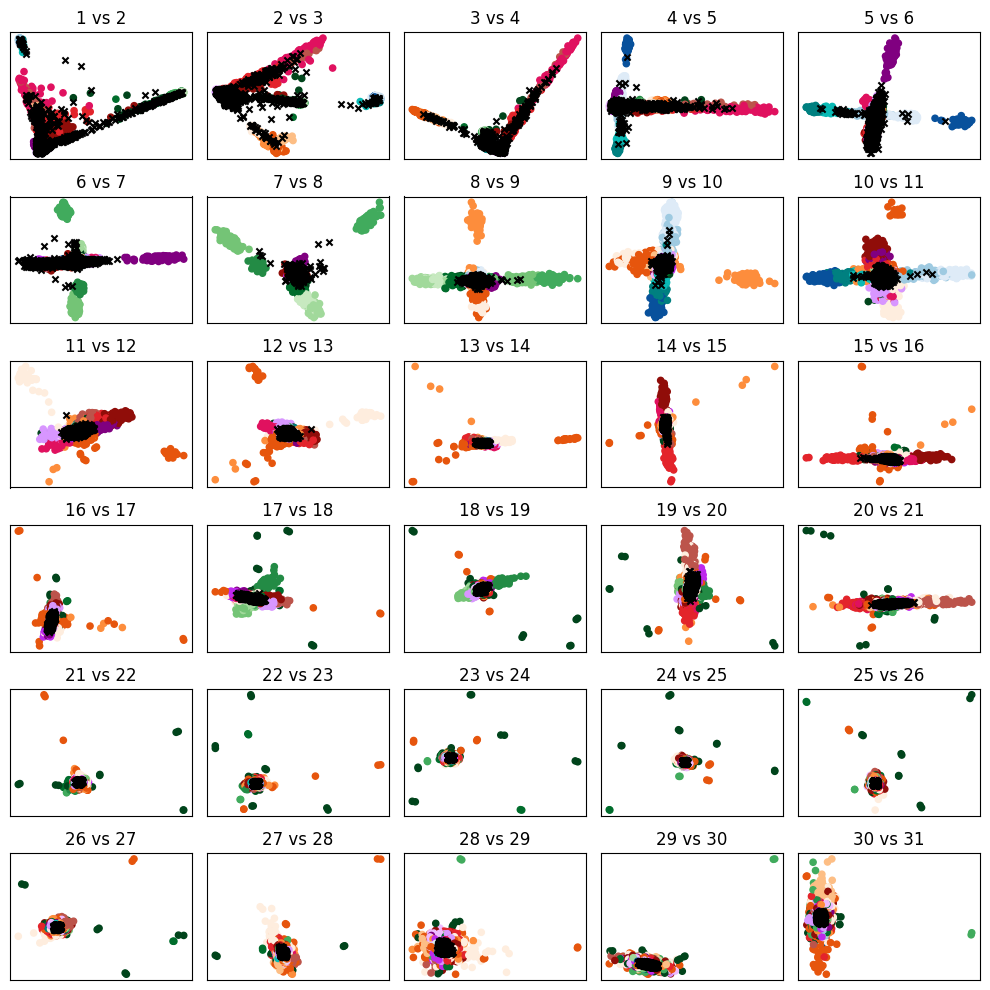

In [59]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        scprep.plot.scatter2d(pca_input_1K[:, [comp-1, comp]], s = 20, cmap = mappings.pop_pallette_1000G_fine, ax=ax[i,j],
                              c = labels_1K['population'], xticks=False, yticks=False,
                              legend=False, title='PCA Plot',fontsize=8)
        scprep.plot.scatter2d(pca_input_mhi[:, [comp-1, comp]], s = 20, c='black', marker='x', ax=ax[i,j],
                              xticks=False, yticks=False,
                              legend=False, title='PCA Plot')

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()


In [11]:
def plot_pca(pca_input):

    fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

    comp = 1
    for i in range(6):
        for j in range(5):
            if (i == 5) & (j == 3):
                scprep.plot.scatter2d(pca_input[[str(comp-1), str(comp)]], ax=ax[i, j],
                                      s=5, c=metadata_mhi['selfreported_pop'], 
                                      cmap=pop_pallette_mhi,
                                      xticks=False, yticks=False, legend=True,
                                      legend_loc='upper center', legend_anchor=(-0.05, -0.05), 
                                      legend_ncol=3, fontsize=16)
            else:
                scprep.plot.scatter2d(pca_input[[str(comp-1), str(comp)]], ax=ax[i, j],
                                      s=5, c=metadata_mhi['selfreported_pop'], 
                                      cmap=pop_pallette_mhi,
                                      xticks=False, yticks=False, legend=False)

            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

            comp += 1

    plt.tight_layout()